# Import Library

In [171]:
import warnings
warnings.filterwarnings("ignore")

import math
import imblearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.svm import SVR, LinearSVC, NuSVC, LinearSVR, NuSVR
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier, NearestCentroid, RadiusNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, GradientBoostingClassifier, \
     AdaBoostClassifier, RandomForestClassifier, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression, SGDClassifier, LogisticRegressionCV, RidgeClassifier, ARDRegression, BayesianRidge, \
     ElasticNetCV, Lars, LarsCV, Lasso, LassoCV, LassoLars, LassoLarsCV, LassoLarsIC, OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV, \
     PassiveAggressiveRegressor, PoissonRegressor, RANSACRegressor, Ridge, RidgeCV, SGDRegressor, TheilSenRegressor, TweedieRegressor

# Load Data

In [172]:
data = pd.read_csv("../Dataset/heart.csv").drop(columns=['FastingBS','Age', 'Sex'])
# data = pd.read_csv("../Dataset/heart.csv")
data.sample(5)

,ChestPainType,RestingBP,Cholesterol,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
386,ASY,145,0,Normal,99,Y,0.0,Flat,1
498,ASY,160,384,ST,130,Y,0.0,Flat,1
445,NAP,136,228,ST,124,Y,1.6,Flat,1
33,ASY,130,172,ST,130,N,2.0,Flat,1
367,ASY,135,0,ST,120,Y,0.0,Up,1


# Inital Analysis

In [159]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ChestPainType   918 non-null    object 
 1   RestingBP       918 non-null    int64  
 2   Cholesterol     918 non-null    int64  
 3   RestingECG      918 non-null    object 
 4   MaxHR           918 non-null    int64  
 5   ExerciseAngina  918 non-null    object 
 6   Oldpeak         918 non-null    float64
 7   ST_Slope        918 non-null    object 
 8   HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 64.7+ KB
None


In [160]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


### Get Numerical and Categorical Columns

In [173]:
numerical_column = [column for column in data.columns if data[column].dtype != 'object']
print(numerical_column)
categorical_column = [column for column in data.columns if data[column].dtype == 'object']
print(categorical_column)

['RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease']
['ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


### Cleaning nan Value 

In [174]:
def set_numerical_nan(data, numerical_column):
    data[numerical_column] = data[numerical_column].fillna(data[numerical_column].mean())
    return data
data = set_numerical_nan(data, numerical_column)

In [175]:
def set_categorical_nan(data, categorical_column):
    imp = SimpleImputer(strategy="most_frequent")
    data[categorical_column] = imp.fit_transform(data[categorical_column])
    return data
data = set_categorical_nan(data, categorical_column)

# Data Exploration

### Distribution value for numerical columns

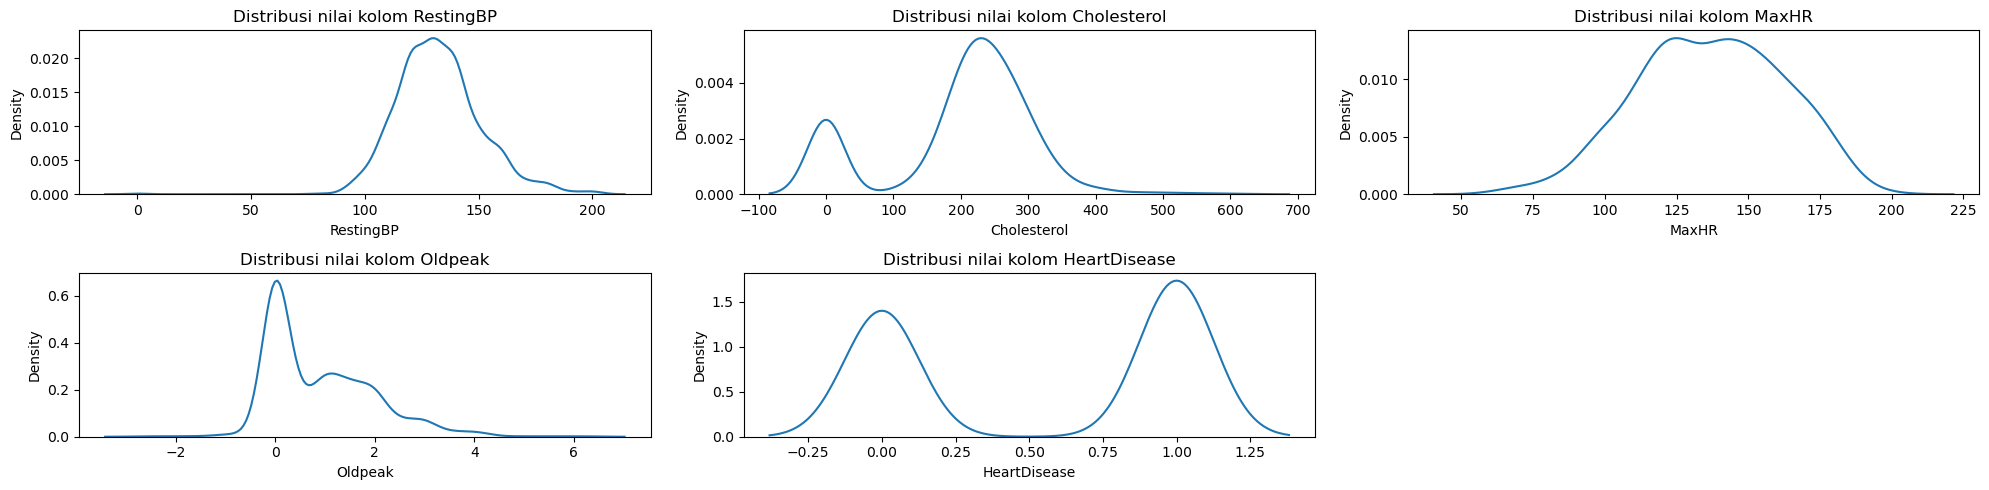

In [110]:
num_rows = 2
num_cols = math.ceil(len(numerical_column) / num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5))
for i, column in enumerate(numerical_column):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data, x=column, ax=axes[row, col]).set_title("Distribusi nilai kolom " + column)
    
for i in range(len(numerical_column), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

### Distribution value for numerical columns based on Gender

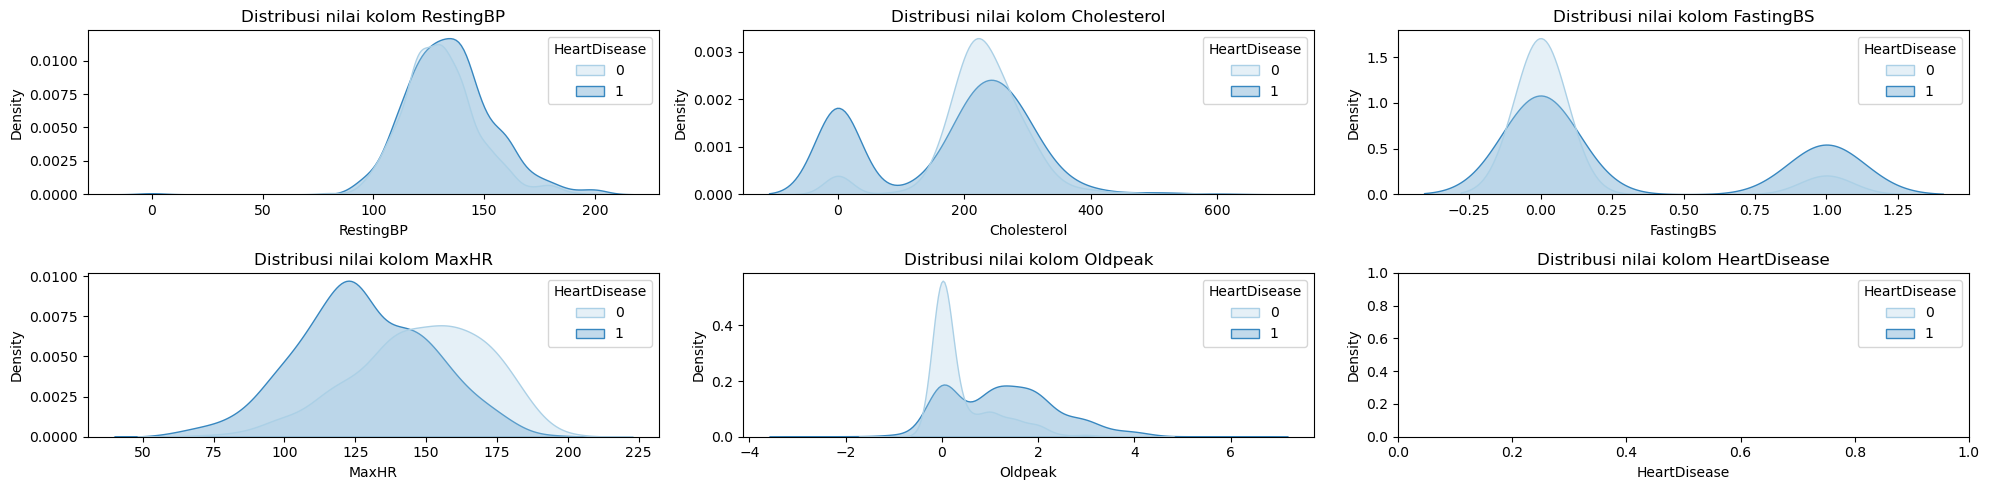

In [9]:
num_rows = 2
num_cols = math.ceil(len(numerical_column) / num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5))
for i, column in enumerate(numerical_column):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data, x=column, hue="HeartDisease", fill=True, alpha=.3, palette="Blues", ax=axes[row, col]).set_title("Distribusi nilai kolom " + column)
    
for i in range(len(numerical_column), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

### Count of each value for categorical columns

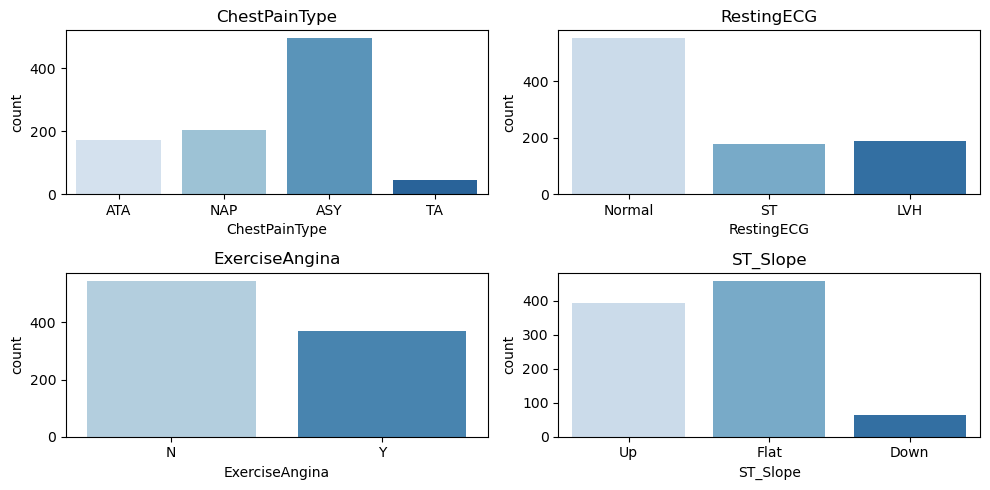

In [10]:
num_rows = 2
num_cols = math.ceil(len(categorical_column) / num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5))
for i, column in enumerate(categorical_column):
    row = i // num_cols
    col = i % num_cols
    sns.countplot(x=data[column], ax=axes[row, col], palette="Blues").set_title(column)
    
    
for i in range(len(categorical_column), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

### The range of values in the numerical column

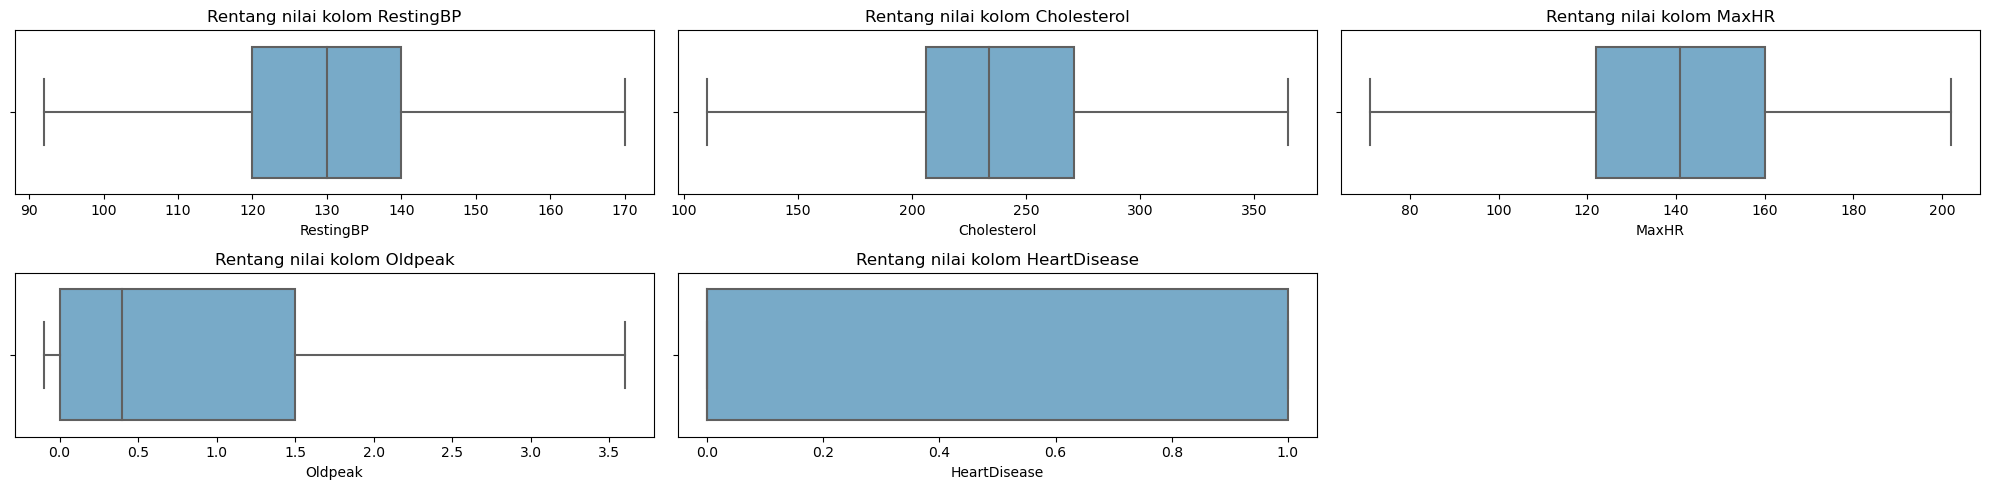

In [183]:
num_rows = 2
num_cols = math.ceil(len(numerical_column) / num_rows)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5))
for i, column in enumerate(numerical_column):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x=data[column], ax=axes[row, col], palette="Blues").set_title("Rentang nilai kolom " + column)
    
for i in range(len(numerical_column), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

### Remove Outlier from the data

In [182]:
Q1   = data.quantile(0.25)
Q3   = data.quantile(0.75)
IQR  = Q3-Q1
data = data[~((data<(Q1-1.5*IQR))|(data>(Q3+1.5*IQR))).any(axis=1)].dropna()
data.shape

(691, 9)

# Data correlation between columns

<Axes: >

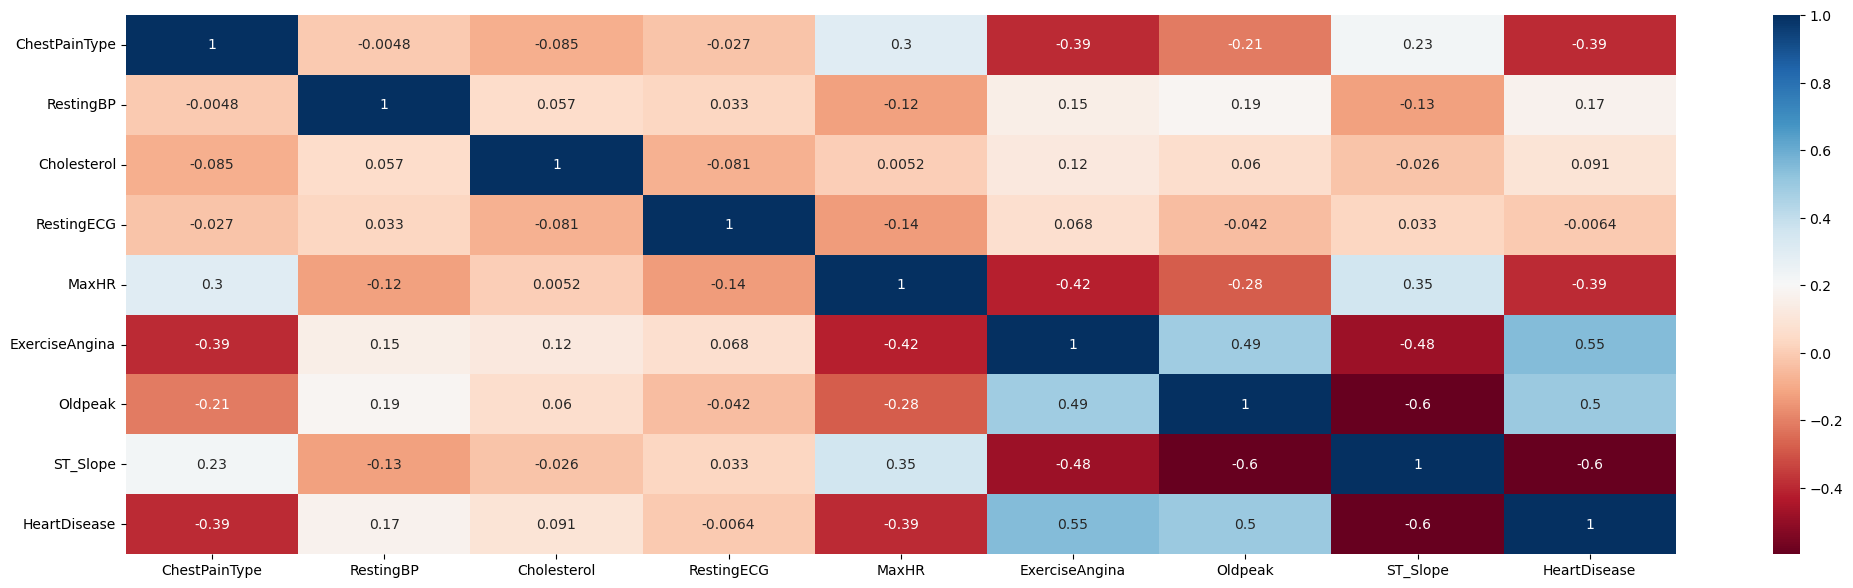

In [184]:
datacorr = data.copy()

encoder = LabelEncoder()
for column in categorical_column:
    datacorr[column] = encoder.fit_transform(datacorr[column])

plt.figure(figsize=(25,7))
corr = datacorr.corr()
sns.heatmap(corr, annot=True, cmap="RdBu")

# Data Preprocessing

In [185]:
data = pd.get_dummies(data, columns = categorical_column)

X = data.drop(columns=['HeartDisease'])
Y = data['HeartDisease'].astype('int8')

print(Counter(Y))
oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)
print(Counter(Y))

# scaler = StandardScaler()
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

Counter({0: 372, 1: 319})
Counter({0: 372, 1: 372})


### Split data to Train and Test data

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

print(f'Total # of sample in whole dataset: {len(X)}')
print(f'Total # of sample in train dataset: {(X_train.shape)}')
print(f'Total # of sample in test dataset: {(X_test.shape)}')

Total # of sample in whole dataset: 744
Total # of sample in train dataset: (595, 16)
Total # of sample in test dataset: (149, 16)


# Model Prediction

### Prepare Model

In [187]:
def algorithms():
    algorithms = [
                    ### Classification ###
                  ('AdaBoost', AdaBoostClassifier(n_estimators=51, learning_rate=0.1, random_state=42)),
                  ('Bernoulli NB', BernoulliNB()),
                  ('Gradient Boost', GradientBoostingClassifier(n_estimators=46, learning_rate=0.1, max_depth=50, random_state=42)),
                  ('KNN', KNeighborsClassifier(n_neighbors=4)),
                  ('Linear SVC',LinearSVC(random_state=42, tol=1e-1)),
                  ('Multinomial NB', MultinomialNB()),
                  ('Nu SVC', NuSVC()),
                  ('Random Forest',RandomForestClassifier(max_depth=7, random_state=42)),
                  ('Ridge',RidgeClassifier()),
                  ('SGD', SGDClassifier(max_iter=63,loss='hinge', penalty='l2', alpha=1e-3, random_state=42, tol=None)),
        
                    ### Regression ###
                  ('ARD',ARDRegression()),
                  ('AdaBoost',AdaBoostRegressor(n_estimators=27, random_state=42)),
                  ('Bayesian Ridge',BayesianRidge()),
                  ('Decision Tree', DecisionTreeRegressor(max_depth=4)),
                  ('Elastic Net CV', ElasticNetCV(random_state=42)),
                  ('Gradient Boost', GradientBoostingRegressor(n_estimators=5, learning_rate=0.1, max_depth=50, random_state=42)),
                  ('Hist Gradient B',HistGradientBoostingRegressor()),
                  ('Kernel Ridge',KernelRidge(alpha=.1)),
                  ('KNN', KNeighborsRegressor(n_neighbors=4)), 
                  ('Lars',Lars(n_nonzero_coefs=26)),
                  ('Lars CV',LarsCV(cv=6)),
                  ('Lasso',Lasso(alpha=1e-4)),
                  ('Lasso CV', LassoCV(cv=6, random_state=42)),
                  ('Lasso Lars', LassoLars(alpha=1e-5)),
                  ('Lasso Lars CV', LassoLarsCV(cv=6)),
                  ('Lasso Lars IC', LassoLarsIC(criterion='aic')),
                  ('Linear Regression', LinearRegression()), 
                  ('Linear Regression CV', LogisticRegressionCV(cv=2, random_state=42)),
                  ('Linear SVR', LinearSVR(random_state=42, tol=1e-5)),
                  ('MLP', MLPRegressor(hidden_layer_sizes=(10000,), max_iter=100, random_state=42)),
                  ('Nu SVR',NuSVR(C=1, nu=0.6)),
                  ('Orthogonal MP', OrthogonalMatchingPursuit()),
                  ('Orthogonal MP CV', OrthogonalMatchingPursuitCV(cv=3)),
                  ('Passive Aggressive',PassiveAggressiveRegressor(max_iter=4, random_state=42, tol=1e-1)),
                  ('Poisson', PoissonRegressor()),
                  ('Random Forrest', RandomForestRegressor(n_estimators=14, max_depth=50, random_state=42)),
                  ('RANSAC', RANSACRegressor(random_state=42)),
                  ('Ridge', Ridge(alpha=.1)),
                  ('RidgeCV', RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])),
                  ('SGD', SGDRegressor(max_iter=116, tol=1e-4, random_state=42)),
                  ('SVR', SVR(kernel='rbf')), 
                  ('TheilSen',TheilSenRegressor(random_state=42)),
                  ('Tweedie', TweedieRegressor(power = 1)),
                  ]
    return algorithms


def prepare_model(algorithm):
    model = algorithm
    model.fit(X_train, y_train)
    return model

def calculate_regression_performance(model, X_train, y_train, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = round(model.score(X_train,y_train), 4)*100
    mse = round(mean_squared_error(y_test, y_pred), 2)
    r2  = round(r2_score(y_test, y_pred), 2)
    return acc, mse, r2

def regression_result(result, name, acc, mse, r2):
    result.append((name, acc, mse, r2))
    return result

### Training and Evaluate the model

In [188]:
%%time
result = []
trained_models = []

algorithms = algorithms()

for index, tup in enumerate(algorithms):
    model = prepare_model(tup[1])
    trained_models.append((tup[0],model))

    # Calculate the Accuracy, Mean Squared Error (MSE), and R-squared score
    acc, mse, r2= calculate_regression_performance(model,X_train, y_train, X_test, y_test)
    result = regression_result(result, tup[0], acc, r2, mse)

regression_results_df = pd.DataFrame(result, columns=('Model Name', 'Accuracy', 'R-Square', 'MSE'))
regression_results_df.sort_values(by=['R-Square', 'Accuracy'], ascending=False)

CPU times: total: 41.8 s
Wall time: 10.1 s


,Model Name,Accuracy,R-Square,MSE
40,SVR,62.79,0.63,0.09
16,Hist Gradient B,90.17,0.62,0.10
35,Random Forrest,91.33,0.61,0.10
29,MLP,78.24,0.61,0.10
30,Nu SVR,57.16,0.60,0.10
13,Decision Tree,61.75,0.58,0.11
23,Lasso Lars,57.80,0.57,0.11
26,Linear Regression,57.80,0.57,0.11
37,Ridge,57.80,0.57,0.11
21,Lasso,57.79,0.57,0.11


### Find optimal hyperparameter for some models

In [202]:
%%time
max_value = 0
num_value = 0
n_number = 200

for i in tqdm(range(n_number)):
  ### Classification ###
    # model = AdaBoostClassifier(n_estimators=i+1, learning_rate=0.1, random_state=42)
    # model = GradientBoostingClassifier(n_estimators=i+1, learning_rate=0.1, max_depth=50, random_state=42)
    # model = KNeighborsClassifier(n_neighbors=i+1)
    # model = LinearSVC(random_state=42, tol=(i+1)/100)
    # model = RandomForestClassifier(max_depth=i+1, random_state=42)
    # model = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=i+1, tol=None)
    
    ### Regression ###
    # model = AdaBoostRegressor( n_estimators=i+1, random_state=42)
    # model = DecisionTreeRegressor(max_depth=i+1)
    # model = GradientBoostingRegressor(n_estimators=i+1, learning_rate=0.1, max_depth=50, random_state=42)
    # model = KernelRidge(alpha=(i+1)/100)
    # model = KNeighborsRegressor(n_neighbors=i+1)
    # model = Lars(n_nonzero_coefs=i+1)
    # model = LarsCV(cv=i+2)
    # model = Lasso(alpha=(i+1)/100)
    # model = LassoCV(cv=i+2, random_state=42)
    # model = LassoLars(alpha=(i+1)/100)
    # model = LassoLarsCV(cv=i+2)
    # model = LogisticRegressionCV(cv=i+2, random_state=42)
    # model = LinearSVR(random_state=42, tol=(i+1)/100)
    # model = NuSVR(C=i+1, nu=1)
    # model = OrthogonalMatchingPursuitCV(cv=i+2)
    # model = PassiveAggressiveRegressor(max_iter=i+1, random_state=42, tol=1e-3)
    # model = RandomForestRegressor(n_estimators=i+1, max_depth=100, random_state=42)
    # model = Ridge(alpha=(i+1)/100)
    # model = SGDRegressor(max_iter=i+1, tol=1e-4, random_state=42)
    # model = TweedieRegressor(power = i)
    
    model.fit(X_train, y_train)
    # Calculate the R-squared score
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    if (r2> max_value):
        max_value = r2
        num_value = i+1
    
print(max_value)
print(num_value)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:16<00:00, 12.11it/s]

0.6208143821525953
88
CPU times: total: 9.7 s
Wall time: 16.5 s
